<a href="https://colab.research.google.com/github/mamuncseru/100-Super-Notebooks/blob/main/EpilepsyDetectionCNNExperimentTensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [2]:
## seed 
np.random.seed(2023)

## Reading CSV data

In [3]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [4]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [5]:
raw_data.values.shape

(11500, 180)

In [6]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [7]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [8]:
# let's see the type 
type(data)

numpy.ndarray

## Classifying data categories as it mentioned in the paper

In [9]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [10]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

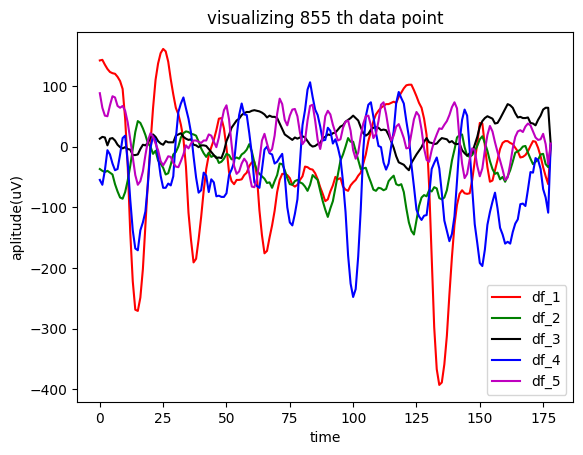

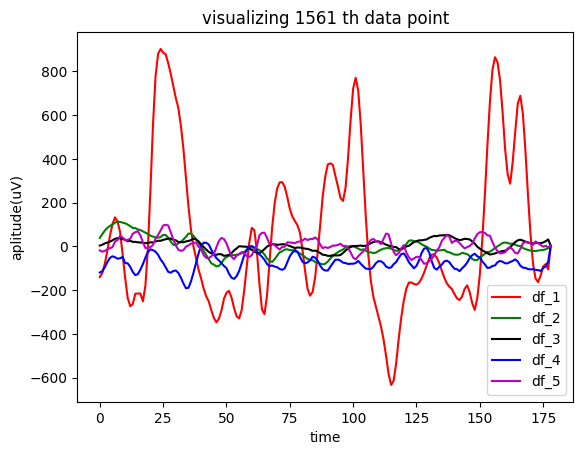

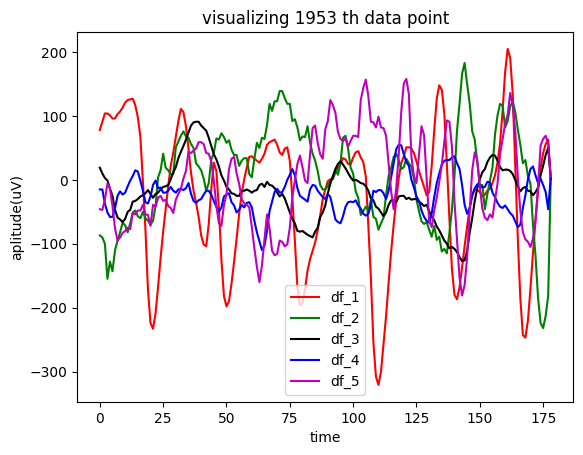

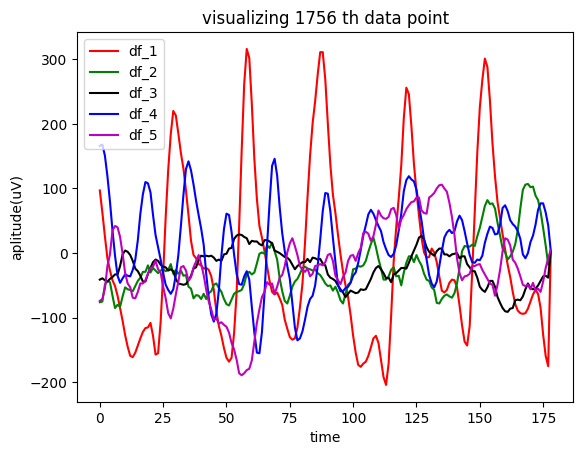

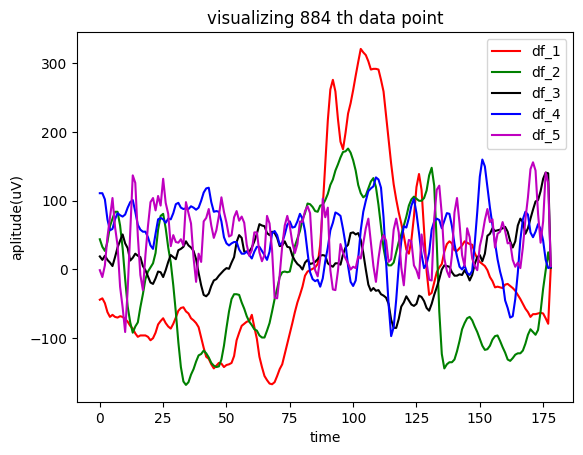

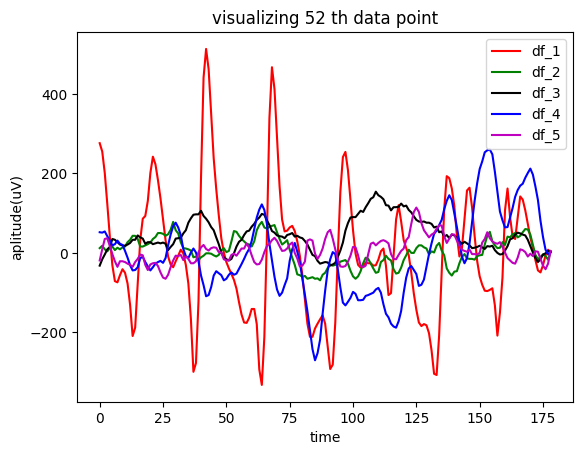

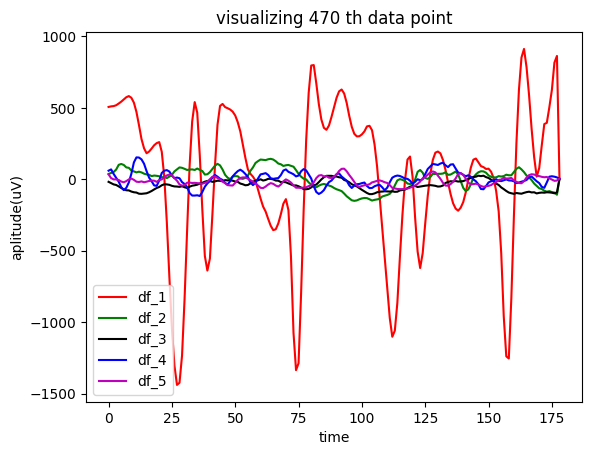

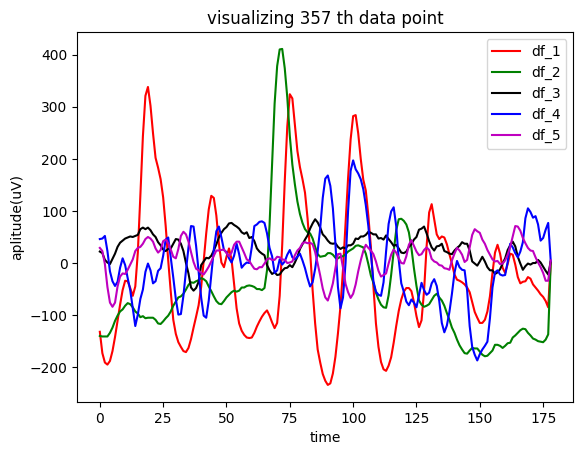

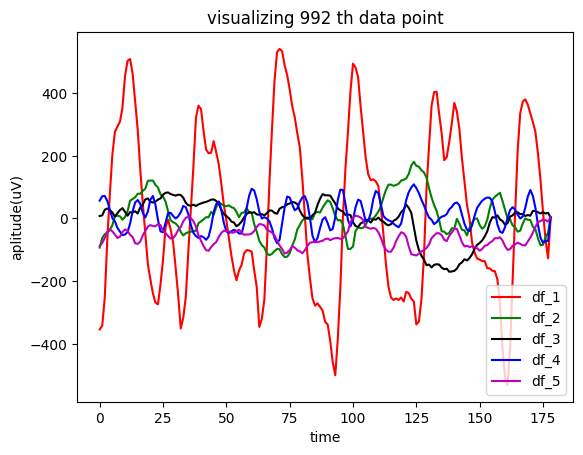

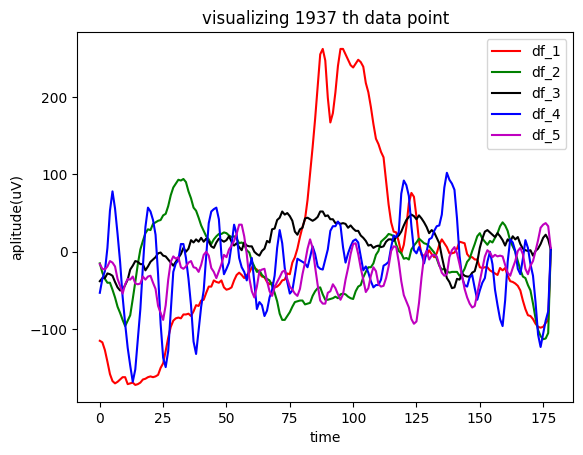

In [11]:
### all categories
visualize_eeg(10)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [12]:
all_data = data.copy().astype('int')

In [13]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [14]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [15]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Merge and Split dataset for training, validation and testing (80%:10%:10%)

In [16]:
def split_data(data, random_state=2023):
    
    X = all_data[:, :-1]
    y = all_data[:, -1]

    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, stratify=y, test_size=.2, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, stratify=y_valtest, test_size=.5, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test



In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(all_data)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(9200, 178)
(1150, 178)
(1150, 178)
(9200,)
(1150,)
(1150,)


### let's expand the dimension to fit the data for CNN modelling

In [18]:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(9200, 178, 1)
(1150, 178, 1)
(1150, 178, 1)


## Defining the CNN network architecture

## Model 1

without activation function and validation set it performs worst...

In [19]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape):
        super(eegClassifier, self).__init__()

        # self.im_shape = (X_train.shape[1], 1)
        # self.inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')
        
        self.conv1 = layers.Conv1D(filters=32, kernel_size=6, input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

        self.conv2 = layers.Conv1D(filters=64, kernel_size=3)
        self.bn_2 = BatchNormalization()
        self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

        
        self.flatten = Flatten()

        self.dense_1 = Dense(32)
        self.dense_2 = Dense(16)

        self.output_dense = Dense(2)

    def call(self, inputs):
        print('I am here entered...')
        x = self.conv1(inputs)
        print('printing the shape: ', x.shape)
        x = self.max_pool_1(self.bn_1(x))
        x = self.conv2(x)
        x = self.max_pool_2(self.bn_2(x))

        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.output_dense(x)

input_shape = (X_train.shape[1], 1)
model = eegClassifier(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
X_train = X_train.astype('float32')
y_train = y_train.astype('int32')

In [20]:
history = model.fit(X_train, y_train, epochs=50)

Epoch 1/50
I am here entered...
printing the shape:  (None, 173, 32)
I am here entered...
printing the shape:  (None, 173, 32)
288/288 [==============================] - 14s 6ms/step - loss: 0.8482 - accuracy: 0.5852
Epoch 2/50
288/288 [==============================] - 2s 5ms/step - loss: 0.6796 - accuracy: 0.4914
Epoch 3/50
288/288 [==============================] - 2s 5ms/step - loss: 0.6351 - accuracy: 0.3968
Epoch 4/50
288/288 [==============================] - 1s 5ms/step - loss: 0.6369 - accuracy: 0.3667
Epoch 5/50
288/288 [==============================] - 2s 5ms/step - loss: 0.6420 - accuracy: 0.3593
Epoch 6/50
288/288 [==============================] - 2s 5ms/step - loss: 0.6413 - accuracy: 0.3596
Epoch 7/50
288/288 [==============================] - 2s 6ms/step - loss: 0.6500 - accuracy: 0.3371
Epoch 8/50
288/288 [==============================] - 2s 7ms/step - loss: 0.6956 - accuracy: 0.2122
Epoch 9/50
288/288 [==============================] - 2s 5ms/step - loss: 0.6941 - 

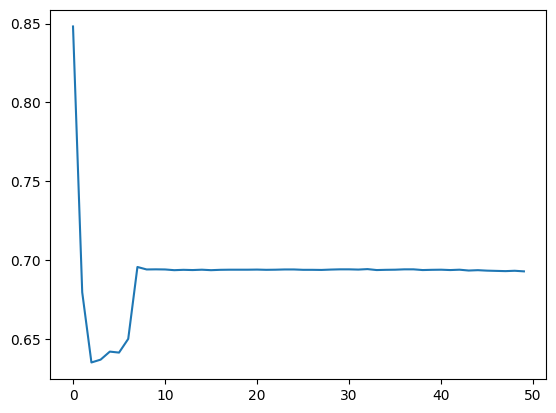

In [21]:
plt.plot(history.history['loss'])

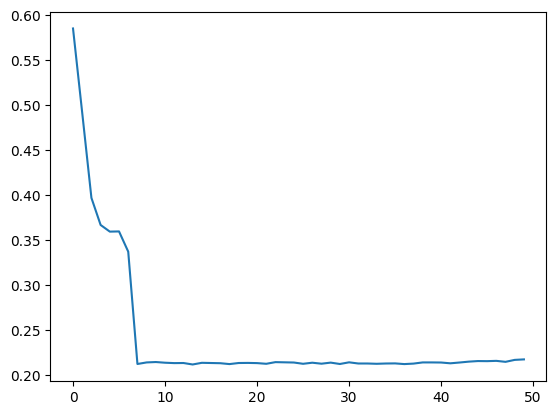

In [22]:
plt.plot(history.history['accuracy'])

## Model 2

In [23]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape):
        super(eegClassifier, self).__init__()

        # self.im_shape = (X_train.shape[1], 1)
        # self.inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')
        
        self.conv1 = layers.Conv1D(filters=32, kernel_size=6, input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

        self.conv2 = layers.Conv1D(filters=64, kernel_size=3)
        self.bn_2 = BatchNormalization()
        self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

        self.flatten = Flatten()

        self.dense_1 = Dense(32)
        self.dense_2 = Dense(16)

        self.output_dense = Dense(2, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(self.bn_1(x))
        x = self.max_pool_1(x)

        x = self.conv2(x)
        x = tf.nn.relu(self.bn_2(x))
        x = self.max_pool_2(x)

        x = self.flatten(x)
        x = self.dense_1(x)
        x = tf.nn.relu(x)
        x = self.dense_2(x)
        x = tf.nn.relu(x)
        return self.output_dense(x)

input_shape = (X_train.shape[1], 1)
model = eegClassifier(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

y_train = y_train.astype('int32')
y_val = y_val.astype('int32')

In [ ]:
history2 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
288/288 [==============================] - 5s 7ms/step - loss: 0.1490 - accuracy: 0.9408 - val_loss: 0.1230 - val_accuracy: 0.9565
Epoch 2/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1143 - accuracy: 0.9553 - val_loss: 0.0970 - val_accuracy: 0.9600
Epoch 3/100
288/288 [==============================] - 2s 6ms/step - loss: 0.1062 - accuracy: 0.9593 - val_loss: 0.0811 - val_accuracy: 0.9730
Epoch 4/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0900 - accuracy: 0.9660 - val_loss: 0.1058 - val_accuracy: 0.9583
Epoch 5/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0799 - accuracy: 0.9715 - val_loss: 0.1008 - val_accuracy: 0.9600
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - loss: 0.0678 - accuracy: 0.9760 - val_loss: 0.0978 - val_accuracy: 0.9678
Epoch 7/100
288/288 [==============================] - 2s 6ms/step - loss: 0.0550 - accuracy: 0.9803 - val_loss: 0.0952 - val_accuracy: 0.9678

### function to plot loss curve of the training and validation loss


In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], 'b-')
    plt.plot(history.history['val_loss'], 'r-')
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss curve')
    plt.xlabel('Epochs') 
    plt.ylabel('Loss %')
    plt.show()

In [ ]:
plot_loss(history2)

### function to plot accuracy curve of the training and validation accuracy


In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], 'b-')
    plt.plot(history.history['val_accuracy'], 'r-')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.title('Accuracy curve')
    plt.xlabel('Epochs') 
    plt.ylabel('accuracy %')
    plt.show()

In [ ]:
plot_accuracy(history2)

## Let's experiment with the number of units in conv1, conv2 layers

```
conv1 = [32, 64, 128, 256, 512]

conv2 = [64, 128, 256, 512, 1024]
```


### Experimental Model

In [ ]:
class eegClassifier(keras.Model):
    def __init__(self, input_shape, c1_units, c2_units):
        super(eegClassifier, self).__init__()

        # self.im_shape = (X_train.shape[1], 1)
        # self.inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')
        
        self.conv1 = layers.Conv1D(filters=c1_units, kernel_size=6, input_shape=input_shape)
        self.bn_1 = BatchNormalization()
        self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

        self.conv2 = layers.Conv1D(filters=c2_units, kernel_size=3)
        self.bn_2 = BatchNormalization()
        self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

        self.flatten = Flatten()

        self.dense_1 = Dense(32)
        self.dense_2 = Dense(16)

        self.output_dense = Dense(2, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(self.bn_1(x))
        x = self.max_pool_1(x)

        x = self.conv2(x)
        x = tf.nn.relu(self.bn_2(x))
        x = self.max_pool_2(x)

        x = self.flatten(x)
        x = self.dense_1(x)
        x = tf.nn.relu(x)
        x = self.dense_2(x)
        x = tf.nn.relu(x)
        return self.output_dense(x)

input_shape = (X_train.shape[1], 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

y_train = y_train.astype('int32')
y_val = y_val.astype('int32')

In [ ]:
conv1 = [32, 64, 128, 256, 512]
conv2 = [64, 128, 256, 512, 1024]


all_history = []

for c1_units in conv1:
    for c2_units in conv2:
        model = eegClassifier(input_shape, c1_units, c2_units)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print('\n\n\n')
        print(f'---- conv1 unit = {c1_units} ---- conv2 unit = {c2_units}-------')
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

        print('\n\n')
        print(model.summary())
        print('\n')
        plot_loss(history)
        plot_accuracy(history) 

        all_history.append(history)
